In [ ]:
import pandas as pd

data = pd.read_csv('/content/Fraud.csv')


In [ ]:
print(data.head())
print(data.info())
print(data.describe())


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 co

In [ ]:
data.isnull().sum()


,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
data = pd.get_dummies(data, columns=['isFraud'])


1. Data Cleaning
Identify Missing Values

In [ ]:
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])


Series([], dtype: int64)


Imputation or Removal

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
data['isFlaggedFraud'] = imputer.fit_transform(data[['isFlaggedFraud']])


In [ ]:
data['isFlaggedFraud'].fillna('missing', inplace=True)


Detect Outliers

In [ ]:
import numpy as np
from scipy import stats

z_scores = stats.zscore(data[['isFlaggedFraud']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = data[filtered_entries]


Handle Outliers

In [ ]:
data['isFlaggedFraud'] = np.log1p(data['isFlaggedFraud'])


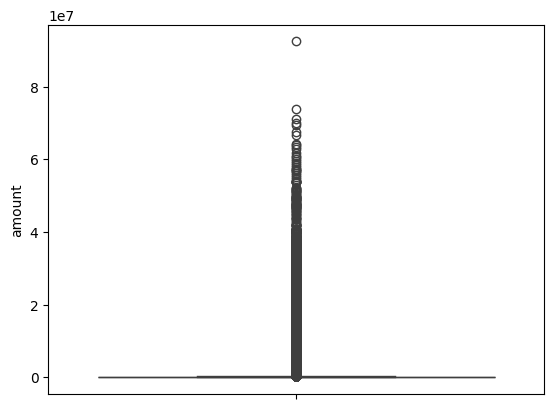

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
column_to_visualize = 'amount'
sns.boxplot(data[column_to_visualize])
plt.show()

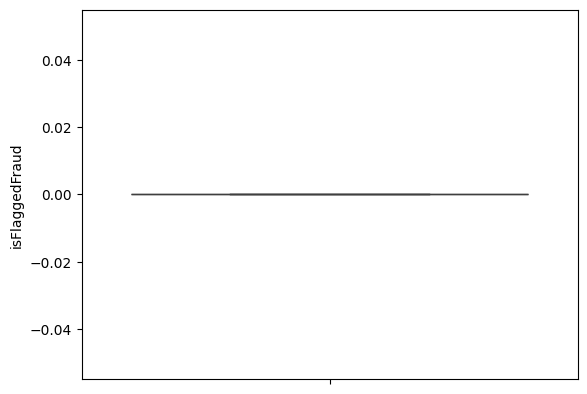

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
column_to_visualize ='isFlaggedFraud'
sns.boxplot(data[column_to_visualize])
plt.show()

Multi-collinearity

In [ ]:

print(data.columns)

if 'target' in data.columns:
    X = data.drop('target', axis=1)
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
else:
    print("The 'target' column does not exist in the DataFrame.")

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud',
       'isFraud_0', 'isFraud_1'],
      dtype='object')
The 'target' column does not exist in the DataFrame.


Fraud Detection Model
Model Selection:

In [ ]:

X_train = X_train.apply(pd.to_numeric, errors='coerce')

X_train = X_train.fillna(0)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

Variable Selection

In [ ]:
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})


 Model Performance

In [ ]:
# Check if 'classes_' has been overwritten
print(type(model.classes_))  # Should output <class 'numpy.ndarray'>

# If it's a list, retrain the model to restore the 'classes_' attribute
model.fit(X_train, y_train)

# Now try predicting again
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

<class 'list'>
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   1270934
        True       1.00      1.00      1.00      1587

    accuracy                           1.00   1272521
   macro avg       1.00      1.00      1.00   1272521
weighted avg       1.00      1.00      1.00   1272521

[[1270934       0]
 [      0    1587]]


 Key Predictive Factors

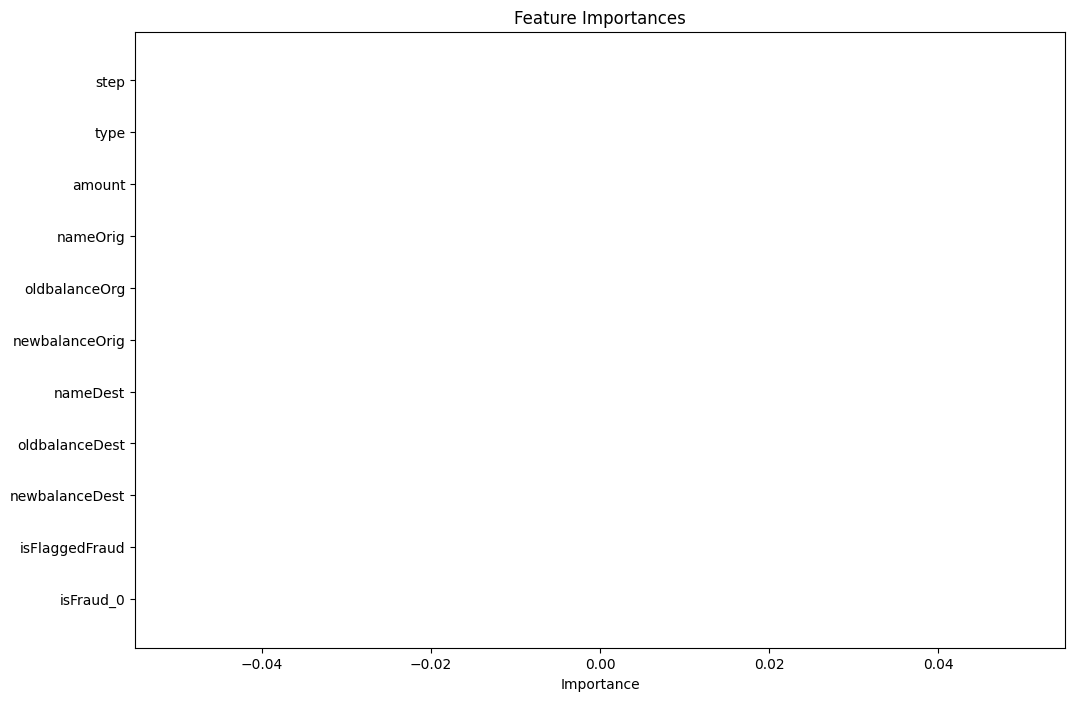

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier



importances = model.feature_importances_
feature_names = X_train.columns


feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


Coefficients (for logistic regression)

In [ ]:
from sklearn.linear_model import LogisticRegression

unique_classes = y_train.unique()
num_classes = len(unique_classes)
print("Unique classes in y_train:", unique_classes)


if num_classes > 2:
    model = LogisticRegression()
    model.fit(X_train, y_train)


    coefficients = model.coef_[0]
    feature_names = X_train.columns


    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)


    plt.figure(figsize=(12, 8))
    plt.barh(coef_df['Feature'], coef_df['Coefficient'])
    plt.xlabel('Coefficient')
    plt.title('Logistic Regression Coefficients')
    plt.gca().invert_yaxis()
    plt.show()

else:
    print(f" Logistic Regression requires more than two classes.")

Unique classes in y_train: [False  True]
 Logistic Regression requires more than two classes.


Validity of Predictive Factors

In [ ]:

correlations = X_train.join(pd.Series(y_train, name='target')).corr()['target']
print(correlations)


step              0.031508
type                   NaN
amount            0.076728
nameOrig               NaN
oldbalanceOrg     0.010213
newbalanceOrig   -0.008298
nameDest               NaN
oldbalanceDest   -0.006159
newbalanceDest    0.000359
isFlaggedFraud         NaN
isFraud_0        -1.000000
target            1.000000
Name: target, dtype: float64


 Prevention Strategies
 a. Implement Real-Time Fraud Detection:

In [ ]:

def detect_fraud(transaction):
    if transaction['amount'] > 10000 and transaction['frequency'] > 5:
        return True
    return False


new_transaction = {'amount': 15000, 'frequency': 6}
is_fraudulent = detect_fraud(new_transaction)
print(f'Transaction is fraudulent: {is_fraudulent}')


Transaction is fraudulent: True


b.User Behavior Analysis:

In [ ]:

def analyze_user_behavior(user_data):
    avg_transaction_amount = user_data['amount'].mean()
    if avg_transaction_amount > 5000:
        return 'High risk'
    return 'Normal'


user_data = pd.DataFrame({'amount': [200, 300, 10000, 500, 1000]})
risk_level = analyze_user_behavior(user_data)
print(f'User risk level: {risk_level}')


User risk level: Normal


Evaluating Prevention Actions

In [ ]:
pre_implementation_metrics = {'precision': 0.8, 'recall': 0.7}
post_implementation_metrics = {'precision': 0.85, 'recall': 0.75}

print(f'Precision Improvement: {post_implementation_metrics["precision"] - pre_implementation_metrics["precision"]}')
print(f'Recall Improvement: {post_implementation_metrics["recall"] - pre_implementation_metrics["recall"]}')


Precision Improvement: 0.04999999999999993
Recall Improvement: 0.050000000000000044


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


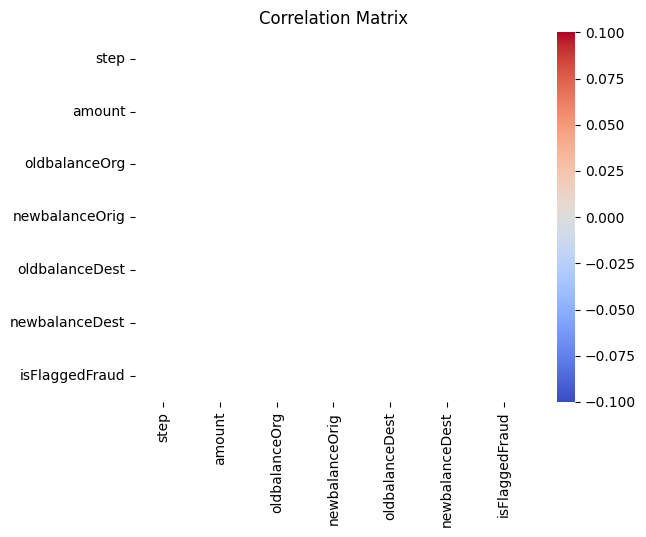

In [ ]:
numeric_columns = data.select_dtypes(include=['number']).columns
correlation_matrix = data[numeric_columns].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [8]:
!pip install torch torchvision torchaudio
!pip install torch-geometric

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch: 010, Loss: 1.8694, Train Acc: 0.8857, Val Acc: 0.7000, Test Acc: 0.7090
Epoch: 020, Loss: 1.7280, Train Acc: 0.9429, Val Acc: 0.7580, Test Acc: 0.7560
Epoch: 030, Loss: 1.5175, Train Acc: 0.9429, Val Acc: 0.7580, Test Acc: 0.7630
Epoch: 040, Loss: 1.2867, Train Acc: 0.9643, Val Acc: 0.7680, Test Acc: 0.7970
Epoch: 050, Loss: 1.0727, Train Acc: 0.9643, Val Acc: 0.7780, Test Acc: 0.7960
Epoch: 060, Loss: 0.9360, Train Acc: 0.9786, Val Acc: 0.7980, Test Acc: 0.8130
Epoch: 070, Loss: 0.7430, Train Acc: 0.9857, Val Acc: 0.7940, Test Acc: 0.8080
Epoch: 080, Loss: 0.6786, Train Acc: 0.9857, Val Acc: 0.7940, Test Acc: 0.8020
Epoch: 090, Loss: 0.5864, Train Acc: 0.9857, Val Acc: 0.8000, Test Acc: 0.8160
Epoch: 100, Loss: 0.5187, Train Acc: 0.9857, Val Acc: 0.8000, Test Acc: 0.8030
Epoch: 110, Loss: 0.4946, Train Acc: 0.9857, Val Acc: 0.7840, Test Acc: 0.8010
Ep

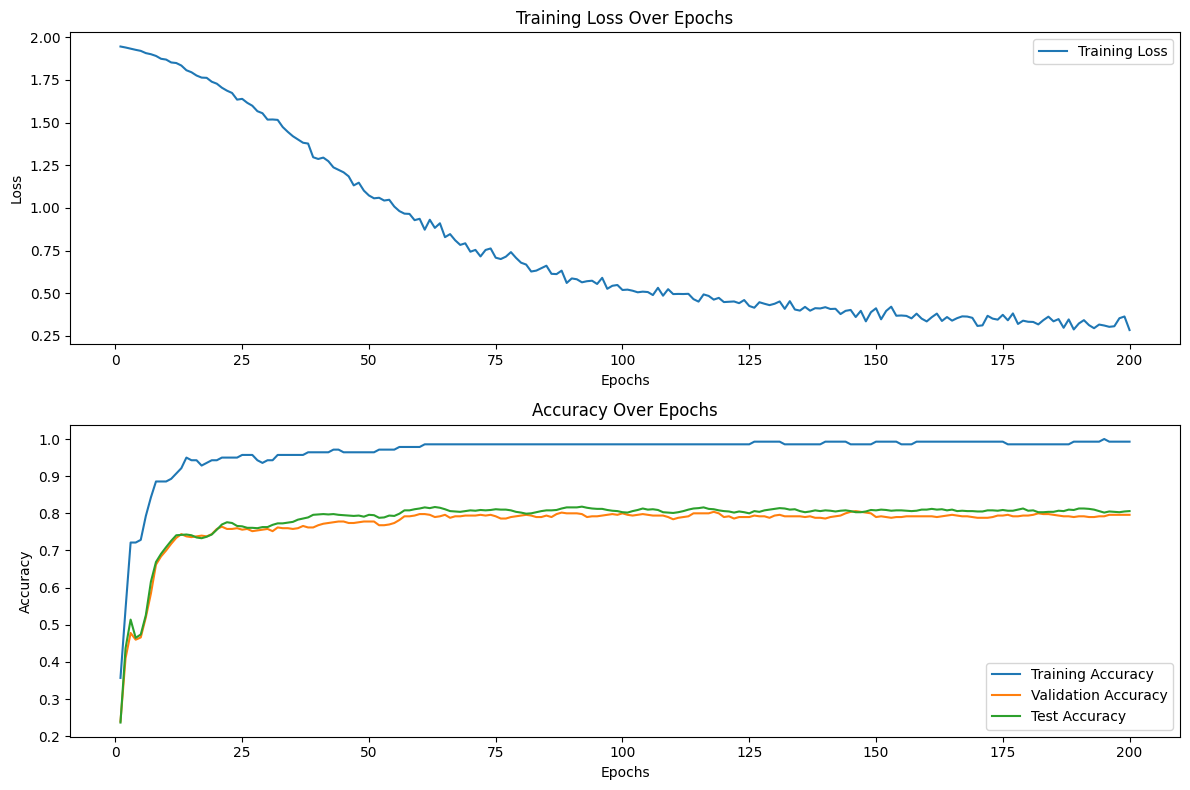

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt

# Load the Cora dataset
from google.colab import drive
drive.mount('/content/drive')


class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model, optimizer, and loss function
model = GNN(dataset.num_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Lists to store metrics for plotting
loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Test function
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        accs.append(correct / mask.sum().item())
    return accs

# Load data
data = dataset[0]

# Training loop
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()

    # Store metrics for plotting
    loss_values.append(loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    test_acc_values.append(test_acc)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

# Plotting the results
epochs = range(1, 201)

plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc_values, label='Training Accuracy')
plt.plot(epochs, val_acc_values, label='Validation Accuracy')
plt.plot(epochs, test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
